In [2]:
import torch
state = torch.load('/root/dev-measure/checkpoint/nk', weights_only=True)
state['model']

OrderedDict([('conv1.weight',
              tensor([[[[-1.3414e-02, -4.2445e-02, -2.2125e-02,  ...,  2.8433e-02,
                          4.3234e-02, -2.5851e-02],
                        [-2.5981e-02,  3.4085e-02, -3.6532e-02,  ...,  3.5723e-02,
                         -7.2007e-03,  3.5057e-02],
                        [ 9.4672e-04,  9.1310e-03, -3.6187e-02,  ...,  2.5233e-02,
                          7.7695e-03, -9.4863e-03],
                        ...,
                        [ 3.5116e-02, -9.3626e-03,  3.9655e-03,  ..., -3.3909e-02,
                          1.6370e-02,  2.8981e-02],
                        [-4.0145e-02, -1.1060e-02, -1.5440e-02,  ...,  1.4106e-02,
                         -1.8608e-02,  3.0471e-02],
                        [ 2.4371e-02,  1.1960e-02,  3.1807e-02,  ..., -1.7033e-02,
                          4.5824e-03,  3.9155e-02]],
              
                       [[-4.5041e-03,  2.9457e-02,  2.9570e-03,  ...,  1.3425e-02,
                         -6.1029

In [13]:
import torch
from torch import tensor
import torch.nn as nn
t1 = tensor([62.1405, 61.2003, 64.2145, 61.8135, 61.7659, 60.6171, 63.4969, 64.8962,
        64.3957, 71.5568, 58.5256, 63.3815, 60.2258, 64.8371, 63.6323, 67.1917])
t2 = tensor([90.4762, 80.9524, 57.1429, 23.8095, 80.9524, 23.8095, 90.4762, 57.1429,
         0.0000, 66.6667, 90.4762, 57.1429,  4.7619, 61.9048, 57.1429, 61.9048])
t1_small = t1/100
t2_small = t2/100
print(t1_small)
import torch.nn.functional as Func
pred_hist = torch.histc(t1_small, bins=10, min=0, max=1)
target_hist = torch.histc(t2_small, bins=10, min=0, max=1)
pred_hist = pred_hist / pred_hist.sum()
target_hist = target_hist / target_hist.sum()
pred_hist = pred_hist + 1e-9
target_hist = target_hist + 1e-9

print(pred_hist)
print(target_hist)
distribution_loss = Func.kl_div(pred_hist.log(), target_hist, reduction='batchmean')
distribution_loss

tensor([0.6214, 0.6120, 0.6421, 0.6181, 0.6177, 0.6062, 0.6350, 0.6490, 0.6440,
        0.7156, 0.5853, 0.6338, 0.6023, 0.6484, 0.6363, 0.6719])
tensor([1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 6.2500e-02,
        8.7500e-01, 6.2500e-02, 1.0000e-09, 1.0000e-09])
tensor([1.2500e-01, 1.0000e-09, 1.2500e-01, 1.0000e-09, 1.0000e-09, 2.5000e-01,
        1.8750e-01, 1.0000e-09, 1.2500e-01, 1.8750e-01])


tensor(1.0621)

1100


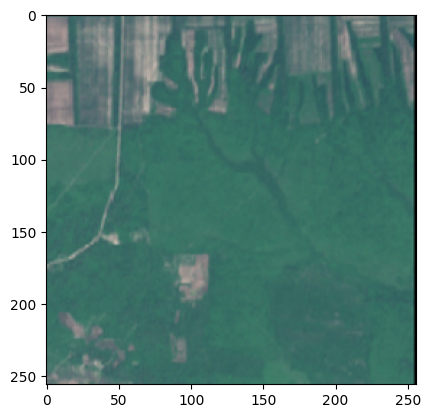

21


In [27]:
import sys
sys.path.append("..")
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torch.backends.cudnn as cudnn
import pandas as pd
from torch.utils.data import DataLoader
from utils.graph import *
from utils.siScore_utils import *
from utils.parameters import *
import os
from itertools import permutations
import copy
from backbone import *
import matplotlib.pyplot as plt

cluster_list = range(22)
dir_name = 'cluster_nk_11_11'

cluster_dataset = ClusterDataset(cluster_list, 
                                     dir_name = dir_name, 
                                     transform = None)
print(cluster_dataset.__len__())
img, label = cluster_dataset.__getitem__(1099)
# show colored image
plt.imshow(img)
plt.show()
print(label)


In [6]:
import sys
sys.path.append("..")
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torch.backends.cudnn as cudnn
import pandas as pd
from torch.utils.data import DataLoader
from utils.graph import *
from utils.siScore_utils import *
from utils.parameters import *
import os
from itertools import permutations
import copy
from backbone import *


class TestDataset(Dataset):
    def __init__(self, transform=None):
        # args.img = 'NK'
        # 在 glob 模式中，* 是一个特殊的通配符，用于匹配任意数量的字符，但不包括路径分隔符（例如 /）。
        # self.file_list = glob.glob('../data/'+args.img+'/*/*.png')
        self.file_list = glob.glob('../data/NK/*/*.png')
        self.transform = transform        

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        path = self.file_list[idx]
        #con = path.split("/")[-3][:3]
        direc = path.split("/")[-2]
        #name = path[-19:-9]
        name = path.split("/")[-1].split(".png")[0]
        name = direc + '*' + name
        #image =  Image.open(path)
        image = io.imread(path) / 255.0
        if self.transform:
            #image =  self.transform(image)
            image = self.transform(np.stack([image])).squeeze()

        return image, name

test_dataset = TestDataset(transform = transforms.Compose([
                                        #transforms.ToTensor(),  
                                        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                        ToTensor(),  
                                        Grayscale(),
                                        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ]))
test_dataset.file_list

['../data/NK/gis/1.png',
 '../data/NK/gis/10.png',
 '../data/NK/gis/100.png',
 '../data/NK/gis/1000.png',
 '../data/NK/gis/1001.png',
 '../data/NK/gis/1002.png',
 '../data/NK/gis/1003.png',
 '../data/NK/gis/1004.png',
 '../data/NK/gis/1005.png',
 '../data/NK/gis/1006.png',
 '../data/NK/gis/1007.png',
 '../data/NK/gis/1008.png',
 '../data/NK/gis/1009.png',
 '../data/NK/gis/101.png',
 '../data/NK/gis/1010.png',
 '../data/NK/gis/1011.png',
 '../data/NK/gis/1012.png',
 '../data/NK/gis/1013.png',
 '../data/NK/gis/1014.png',
 '../data/NK/gis/1015.png',
 '../data/NK/gis/1016.png',
 '../data/NK/gis/1017.png',
 '../data/NK/gis/1018.png',
 '../data/NK/gis/1019.png',
 '../data/NK/gis/102.png',
 '../data/NK/gis/1020.png',
 '../data/NK/gis/1021.png',
 '../data/NK/gis/1022.png',
 '../data/NK/gis/1023.png',
 '../data/NK/gis/1024.png',
 '../data/NK/gis/1025.png',
 '../data/NK/gis/1026.png',
 '../data/NK/gis/1027.png',
 '../data/NK/gis/1028.png',
 '../data/NK/gis/1029.png',
 '../data/NK/gis/103.png',
 

In [19]:
import sys
sys.path.append("..")
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torch.backends.cudnn as cudnn
import pandas as pd
from torch.utils.data import DataLoader
from utils.graph import *
from utils.siScore_utils import *
from utils.parameters import *
import os
from itertools import permutations
import copy

graph_config = '../graph_config/nk.txt'
start, end, partial_order, cluster_unify = graph_process(graph_config)
print(f'cluster_unify: {cluster_unify}')
print(f'partial_order: {partial_order}')

def get_cluster_target_scores(partial_order, cluster_unify):
    cluster_rank = []
    for pair in partial_order:
        if [pair[1]] not in cluster_rank:
            cluster_rank.append([pair[1]])
        cluster_rank.append([pair[0]])
    # 现在cluster_rank中包含了所有的cluster排序，从左到右表示发展水平由低到高
    # 接下来将cluster_unify中的cluster对应到cluster_rank中
    # 比如cluster_rank是[[1], [0], [5], [14], [17], [13], [12], [19]]
    # cluster_unify是[[1, 2, 3, 4, 6], [0, 7], [5, 8, 9, 10], [14, 15, 16, 20], [17, 21], [13, 18], [11, 12]]
    # 那么我希望cluster_rank变为[[1, 2, 3, 4, 6], [0, 7], [5, 8, 9, 10], [14, 15, 16, 20], [17, 21], [13, 18], [11, 12], [19]]
    for rank in cluster_rank:
        for cluster in cluster_unify:
            if rank[0] in cluster:
                # 替换原本的rank为cluster
                cluster_rank[cluster_rank.index(rank)] = cluster
                break
    
    # 接下来为cluster_rank里面每个簇赋分数，最低的簇赋0分，最高的簇赋1分
    # 从左到右依次赋分
    cluster_target_scores = {}
    for i in range(len(cluster_rank)):
        for j in range(len(cluster_rank[i])):
            cluster_target_scores[cluster_rank[i][j]] = 1- i/(len(cluster_rank)-1)

    return cluster_target_scores

get_cluster_target_scores(partial_order, cluster_unify)

cluster_unify: [[1, 2, 3, 4, 6, 7], [5, 8, 9, 10], [14, 15, 16, 20], [17, 21], [13, 18], [11, 12]]
partial_order: [[0, 1], [5, 0], [14, 5], [17, 14], [13, 17], [12, 13], [19, 12]]


{1: 1.0,
 2: 1.0,
 3: 1.0,
 4: 1.0,
 6: 1.0,
 7: 1.0,
 0: 0.8571428571428572,
 5: 0.7142857142857143,
 8: 0.7142857142857143,
 9: 0.7142857142857143,
 10: 0.7142857142857143,
 14: 0.5714285714285714,
 15: 0.5714285714285714,
 16: 0.5714285714285714,
 20: 0.5714285714285714,
 17: 0.4285714285714286,
 21: 0.4285714285714286,
 13: 0.2857142857142857,
 18: 0.2857142857142857,
 11: 0.1428571428571429,
 12: 0.1428571428571429,
 19: 0.0}

In [10]:
import numpy as np
lam = np.random.beta(1.0, 1.0)
lam

0.9475729580147612